<a href="https://colab.research.google.com/github/D-314/FoWC/blob/main/lab1_FoWC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


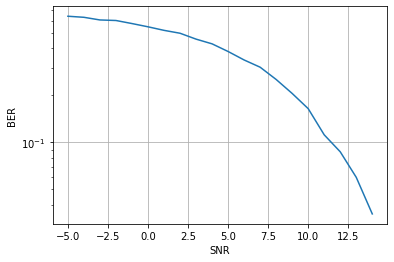

In [ ]:
import multiprocessing as mp
import numpy as np

# Variables below are per-process instances initialized at init_pool function
# Random number generator instance
G_RNG_INSTANCE = None


def init_pool(n_workers=None):
    """
    Initialize a multiprocessing pool
    """
    # The number of workers. If None, use the cpu_count() value
    if n_workers is None:
        n_workers = mp.cpu_count()

    # Initialize the seed sequence for child processes:
    manager = mp.Manager()
    queue = manager.Queue()
    for rng in get_seed_list(n_workers):
        queue.put(rng)
    return mp.Pool(
        processes=mp.cpu_count(),
        initializer=init_worker,
        initargs=(queue,)
    )


def set_rng_seed(seed_value):
    """
    Set the seed value for multiprocessing pool
    """
    global G_RNG_INSTANCE
    G_RNG_INSTANCE = np.random.default_rng(seed_value)


def init_worker(queue):
    """
    Initialize random number generator seed and set shared memory pointer
    """
    set_rng_seed(queue.get())


def get_seed_list(n_workers):
    """
    Generate SeedSequence
    """
    seed_sequence = np.random.SeedSequence()
    return seed_sequence.spawn(n_workers)


def get_rng_instance():
    """
    Get the RNG instance (inside worker)
    """
    return G_RNG_INSTANCE


def fcn(rng, snr_db):
    #rng = np.random.default_rng()
    #snr_db = 10

    rate = 1/2
    k = 2
    n = int(k/rate)
    M = 2 ** k

    codebook = np.array(rng.standard_normal(size=(n, M)) + 1j * rng.standard_normal(size=(n, M))) #
    codebook /= np.linalg.norm(codebook, axis=0)*np.sqrt(n)

    ind = np.random.randint(0, M-1);
    cwd = np.reshape(codebook[:,ind],(n,1))
    
    Eb = 1 #W
    sigma = np.sqrt(Eb / (2 * (10 ** (snr_db / 10 ))))
    Noise = sigma*(np.random.randn(n,1) + 1j * np.random.randn(n,1))
    cwd_RX = cwd + Noise

    dist = np.linalg.norm(codebook-cwd_RX, axis = 0)
    ind_rx = np.argmin(dist)
    #print('{} {}'.format(ind, ind_rx))

    return (ind != ind_rx)


def eval_fcn(snr_db):
    """
    This function takes per-process RNG instance to evaluate single experiment
    """
    return fcn(get_rng_instance(), snr_db)


from tqdm import tqdm
import matplotlib.pyplot as plt

if __name__ == '__main__':
    BER = []
    for snr_db in tqdm(range(-5,15)):
        with init_pool() as pool:
            #snr_db = 8
            n_tests = 1
            errors = np.array(pool.map(eval_fcn, [snr_db] * n_tests))
            BER.append(np.mean(errors))

    plt.plot(range(-5,15), BER)
    plt.yscale('log')
    plt.xlabel('SNR')
    plt.ylabel('BER')
    plt.grid()

In [ ]:
rng = np.random.default_rng()
snr_db = 10

rate = 1/2
k = 2
n = int(k/rate)
M = 2 ** k

codebook = np.array(rng.standard_normal(size=(n, M)) + 1j * rng.standard_normal(size=(n, M))) #
codebook /= np.linalg.norm(codebook, axis=0)

ind = np.random.randint(0, M-1);
cwd = np.reshape(codebook[:,ind],(n,1))

Eb = 1 #W
sigma = np.sqrt(Eb / (2 * (10 ** (snr_db / 10 ))))
Noise = sigma*(np.random.randn(n,1) + 1j * np.random.randn(n,1))
cwd_RX = cwd + Noise


dist = np.linalg.norm(codebook-cwd_RX, axis = 0)
ind_rx = np.argmin(dist)
cwd_RX.shape
dist
np.linalg.norm(codebook, axis = 1)

array([1.1440689 , 0.84916267, 0.70527111, 1.21351628])